## 1. Problem Scope 

### Problem Statement
Design an AI system that predicts whether a patient will be readmitted to the hospital within 30 days after being discharged. The goal is to identify at-risk patients early and reduce unnecessary readmissions, which strain healthcare resources and impact patient outcomes.

### Objectives
1. Predict 30-day readmission risk for each discharged patient.
2. Support early intervention by medical staff for high-risk cases.
3. Reduce overall hospital readmission rates and improve patient care.

### Stakeholders
- **Hospital Administrators** – for cost and resource optimization.
- **Doctors and Nurses** – to prioritize high-risk patients.
- **Patients and Caregivers** – to receive better follow-up care.
- **Health Insurance Providers** – to reduce avoidable claims.


## 2. Data Strategy (10 points)

### Selected Dataset
**Dataset:** Diabetes 130-US hospitals for readmission prediction  
**Source:** [Kaggle – Brandão Diabetes Readmission Dataset](https://www.kaggle.com/datasets/brandao/diabetes)  
This dataset includes over 100,000 hospital admissions for diabetes patients, with features spanning demographics, clinical data, treatments, and readmission status.

---

### Data Sources
1. **Electronic Health Records (EHRs)**  
   - Diagnosis codes: `diag_1`, `diag_2`, `diag_3`  
   - Lab tests: `num_lab_procedures`, `num_procedures`, `number_lab_procedures`

2. **Demographic Data**  
   - `race`, `gender`, `age`

3. **Hospital Administrative Data**  
   - Admission/discharge details: `admission_type_id`, `discharge_disposition_id`, `admission_source_id`  
   - Hospital stay length: `time_in_hospital`

4. **Medication & Treatment Records**  
   - Medications and dosing: `metformin`, `repaglinide`, `insulin`, etc.  
   - Treatment change indicator: `change`

5. **Readmission Outcome**  
   - `readmitted`: categories `<30`, `>30`, `NO`, which will be converted to a binary target (`<30` = 1, otherwise = 0)

---

### Ethical Concerns

1. **Patient Privacy & Confidentiality**  
   - Although the dataset is de-identified, risks remain (e.g. re-identification via combination with external data).  
   - Must implement secure storage (encryption, access controls) and avoid sharing sensitive info.

2. **Algorithmic Bias & Fairness**  
   - Certain demographics (e.g., racial groups or age brackets) may be underrepresented.  
   - If uncorrected, the model could underperform for minority groups, perpetuating disparities in post-discharge care.

---

### Preprocessing Pipeline Design

#### 1. **Data Cleaning**
- Replace placeholder values like `?` with `NaN`.
- Decide whether to drop or impute missing values based on data quality.
- Remove duplicate rows.
- Filter out non-applicable `discharge_disposition_id` values (e.g., transfers to hospice or death).

#### 2. **Feature Encoding**
- Encode categorical variables (`race`, `gender`, `admission_type_id`, `discharge_disposition_id`, `medical_specialty`) via one-hot encoding or label encoding.
- Standardize medication columns (`metformin`, etc.) to indicate whether the patient was on the medication (e.g., binary coding).

#### 3. **Target Encoding**
- Convert `readmitted` to binary:
  - `<30` → 1 (readmitted within 30 days)  
  - `NO` or `>30` → 0 (not readmitted within 30 days)

#### 4. **Normalization/Scaling**
- Apply `MinMaxScaler` or `StandardScaler` to numerical fields (`time_in_hospital`, `num_lab_procedures`, `number_inpatient`, etc.) to improve model convergence.

#### 5. **Feature Engineering**
- **`has_prior_readmission`**: flag as 1 if `number_inpatient` > 0, else 0.
- **`medication_change_flag`**: 1 if `change` == ‘Ch’, else 0.
- **Age binning**: convert `age` intervals (e.g., `[0–10)`, `[10–20)`, etc.) to numeric ordinal codes for easier modeling.

#### 6. **Class Imbalance Handling**
- If the `<30 days` class is underrepresented, apply SMOTE or perform undersampling of the majority class to balance the dataset.

---

*Actual implementation of this pipeline will be coded in the next step (Step 3).*  


## Step 3: Model Development

### Model Chosen: Random Forest Classifier

**Why Random Forest?**
- Works well with high-dimensional, structured data like hospital records.
- Can handle missing data and imbalanced datasets better than many linear models.
- Provides interpretability via feature importance — crucial in medical decision support.
- Reduces overfitting compared to a single decision tree.

---

### Data Loading and Preparation


In [7]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

# Load dataset
df = pd.read_csv('diabetic_data.csv')

# Preview data
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


---

###  Data Understanding & Exploration


Dataset shape: (101766, 50)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures     

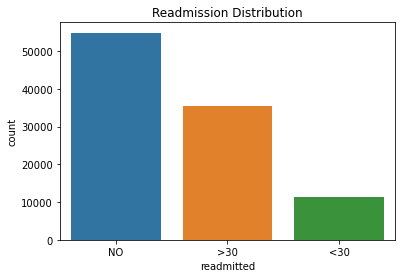

In [8]:
# Shape of the dataset
print("Dataset shape:", df.shape)

# Data types and non-null counts
print("\nData info:")
print(df.info())

# Missing values (including '?')
print("\nMissing values (using '?'):")
print((df == '?').sum().sort_values(ascending=False).head(10))

# Unique values in key categorical columns
print("\nReadmission value counts:")
print(df['readmitted'].value_counts())

print("\nAdmission type value counts:")
print(df['admission_type_id'].value_counts())

# Target distribution check
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='readmitted', data=df)
plt.title('Readmission Distribution')
plt.show()


##  Findings

### Dataset Overview
- **Total Records:** 101,766  
- **Total Features:** 50  
- Each row represents a unique hospital encounter for a diabetic patient.

---

### Data Types and Structure
- Columns include both numeric (`int64`, `float64`) and categorical (`object`) types.
- No columns contain null values in standard format (`NaN`), but several contain `'?'` as placeholders for missing data.
- Many categorical columns (e.g., `race`, `weight`, `payer_code`, `medical_specialty`) need to be cleaned or transformed.

---

###  Missing/Unknown Values
- Some columns contain a high number of `'?'` entries (non-standard missing values):

| Column              | Missing Values (`?`) | % Missing (Approx.) |
|---------------------|----------------------|----------------------|
| `weight`            | ~97,000+             | ~97%                 |
| `payer_code`        | ~40,000+             | ~40%                 |
| `medical_specialty` | ~49,000+             | ~49%                 |

**Action Needed:** Handle these via imputation, grouping, or removal depending on their relevance.

---

### Key Categorical Distributions

#### `readmitted` (Target Variable)
- Value counts:
  - `NO` – Not readmitted → **54%**
  - `>30` – Readmitted after 30 days → **35%**
  - `<30` – Readmitted within 30 days → **11%**

 **Note:** This indicates a **class imbalance**, which must be addressed before modeling.

#### `admission_type_id`
- Most common values:
  - `1`: 53,990 (likely Emergency)
  - `3`, `2`, `6`: Also fairly common
  - `4`, `7`, `8`: Very rare, might be grouped or removed during preprocessing

---

### Visualizations
- **Readmission Distribution Plot** confirms the imbalance in target classes:
  - Majority of records fall under "NO"
  - Fewer instances of `<30` (our main class of interest)

---

### Summary of Key Findings
- Large, structured dataset with a mix of clinical and administrative data.
- Several columns contain non-standard missing values (`?`).
- The target variable (`readmitted`) is imbalanced.
- Some features such as `encounter_id` and `patient_nbr` are identifiers and may not be useful for prediction.
- Feature engineering and careful preprocessing will be essential before modeling.

---



## Data Preprocessing & Feature Engineering
### To prepare the dataset for modeling, we performed the following preprocessing and feature engineering steps:

# 1. Handle Missing and Placeholder Values

### Some features contain '?' to represent missing values. We replaced these with NaN and dropped columns with excessive missing data

In [9]:
import numpy as np

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Drop columns with many missing values
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)


# 2. Remove Irrelevant Identifiers
Columns like encounter_id and patient_nbr are unique identifiers that don't contribute to prediction. We dropped them.

In [10]:
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)


# 3. Encode Target Variable
We simplified the target column readmitted into a binary classification:

- <30 = 1 (High-risk readmission)

- NO and >30 = 0 (Low-risk or no readmission)

In [11]:
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)


# 4. Encode Categorical Features
We used one-hot encoding for categorical columns to make them machine-readable.

In [16]:
high_card_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() > 100]
df.drop(columns=high_card_cols, inplace=True)

categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


# 5. Normalize Numerical Features
We scaled numeric columns to the same range using MinMaxScaler, which helps most ML models perform better.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Exclude target from scaling
features = df.drop(columns=['readmitted'])
df_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
df_scaled['readmitted'] = df['readmitted'].values

MemoryError: Unable to allocate 1.77 GiB for an array with shape (2332, 101766) and data type float64

 Final Check
We confirm the shape and preview the preprocessed dataset.

In [15]:
print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (101766, 2333)


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
0,0.714286,0.888889,0.00,0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,...,0,1,0,0,0,0,0,0,1,0
1,0.000000,0.000000,0.25,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,...,1,1,0,0,0,0,0,0,0,1
2,0.000000,0.000000,0.25,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,...,0,1,0,0,0,0,0,0,1,1
3,0.000000,0.000000,0.25,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,...,1,1,0,0,0,0,0,0,0,1
4,0.000000,0.000000,0.25,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,...,0,1,0,0,0,0,0,0,0,1
